# Olist E-Commerce: Data Preprocessing Pipeline

**Project:** Customer Satisfaction Prediction  
**Dataset:** Olist Brazilian E-Commerce (Kaggle)  
**Objective:** Consolidate and clean 8 relational tables into a final modeling-ready dataset

## Project Structure

1. **Load and initial exploration** of individual tables
2. **Cleaning and transformation** of variables
3. **Basic feature engineering**
4. **Joins and consolidation** into final table
5. **Validation and export**

## Processed Tables

- `olist_orders_dataset.csv` → Orders and dates
- `olist_products_dataset.csv` → Product characteristics
- `olist_customers_dataset.csv` → Customer information
- `olist_sellers_dataset.csv` → Seller data
- `olist_order_items_dataset.csv` → Items per order
- `olist_order_payments_dataset.csv` → Payment information
- `olist_order_reviews_dataset.csv` → Customer reviews
- `product_category_name_translation.csv` → Category translations

In [2]:
# =============================================================================
# LIBRARIES IMPORTS
# =============================================================================

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from unidecode import unidecode

# Visualization settings
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ Libraries loaded successfully")

✅ Libraries loaded successfully


## Data Loading and Exploration

Loading the 8 Olist dataset tables and exploring their basic structure.

Download from: https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce

In [4]:
# =============================================================================
# TABLES IMPORTS
# =============================================================================

data_orders = pd.read_csv("olist_orders_dataset.csv")
data_products = pd.read_csv("olist_products_dataset.csv")
data_categories = pd.read_csv("product_category_name_translation.csv")
data_customers = pd.read_csv("olist_customers_dataset.csv")
data_reviews = pd.read_csv("olist_order_reviews_dataset.csv")
data_pay = pd.read_csv("olist_order_payments_dataset.csv")
data_sellers = pd.read_csv("olist_sellers_dataset.csv")
data_items = pd.read_csv("olist_order_items_dataset.csv")

print("✅ Tables loaded successfully")

✅ Tables loaded successfully


In [5]:
# =============================================================================
# DEFINING DATA EXPLORATION FUNCTION
# =============================================================================
def table_exploration(df, name="Dataset"):
    print(f"--- PRELIMINARY ANALYSIS: {name} ---")
    
    # Summary Table
    summary = pd.DataFrame({
        'Dtype': df.dtypes,
        'Nulls': df.isnull().sum(),
        'Null %': (df.isnull().sum() / len(df) * 100).round(2),
        'Uniques': df.nunique()
    })
    
    print(f"Shape: {df.shape[0]} rows, {df.shape[1]} columns")
    print(f"Duplicate Rows: {df.duplicated().sum()}")
    print("-" * 30)
    print(summary)
    print("-" * 30)
    print("Quick Look (First 3 rows):")
    return df.head(3)

print("✅ Function defined successfully")

✅ Function defined successfully


### Orders Processing

**Cleaning decisions:**

1. **Date normalization**: Removed timestamps (time) as analysis is daily-based
2. **Status normalization**: Applied the same text format to facilitate further analysis
3. **Derived target variables**: 
   - `delivered_status` (1 if delivered, 0 otherwise)
   - `waiting_time` (days of delay vs. purchase date)
4. **Handling undelivered orders**: Imputed `waiting_time = max_waiting_observed + 30` to keep a realistic value penalizing undelivered orders without impacting the model too much
5. **Dropping redundant columns**: Keeping only derived target variables and purchase date for analysis and id for future merges

**Rationale**: Converting categorical status to numerical metrics facilitates downstream modeling.

In [7]:
table_exploration(data_orders, "Orders")

--- PRELIMINARY ANALYSIS: Orders ---
Shape: 99441 rows, 8 columns
Duplicate Rows: 0
------------------------------
                                Dtype  Nulls  Null %  Uniques
order_id                       object      0    0.00    99441
customer_id                    object      0    0.00    99441
order_status                   object      0    0.00        8
order_purchase_timestamp       object      0    0.00    98875
order_approved_at              object    160    0.16    90733
order_delivered_carrier_date   object   1783    1.79    81018
order_delivered_customer_date  object   2965    2.98    95664
order_estimated_delivery_date  object      0    0.00      459
------------------------------
Quick Look (First 3 rows):


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00


In [8]:
# =============================================================================
# DATE & STATUS NORMALIZATION
# =============================================================================

data_orders["order_purchase_timestamp"] = pd.to_datetime(data_orders["order_purchase_timestamp"]).dt.normalize() # datetime64[ns]
data_orders["order_delivered_customer_date"] = pd.to_datetime(data_orders["order_delivered_customer_date"]).dt.normalize()
data_orders["order_estimated_delivery_date"] = pd.to_datetime(data_orders["order_estimated_delivery_date"]).dt.normalize()
data_orders["order_delivered_carrier_date"] = pd.to_datetime(data_orders["order_delivered_carrier_date"]).dt.normalize()

data_orders["order_status"] = data_orders["order_status"].apply(unidecode).str.strip().str.lower()
data_orders.shape

(99441, 8)

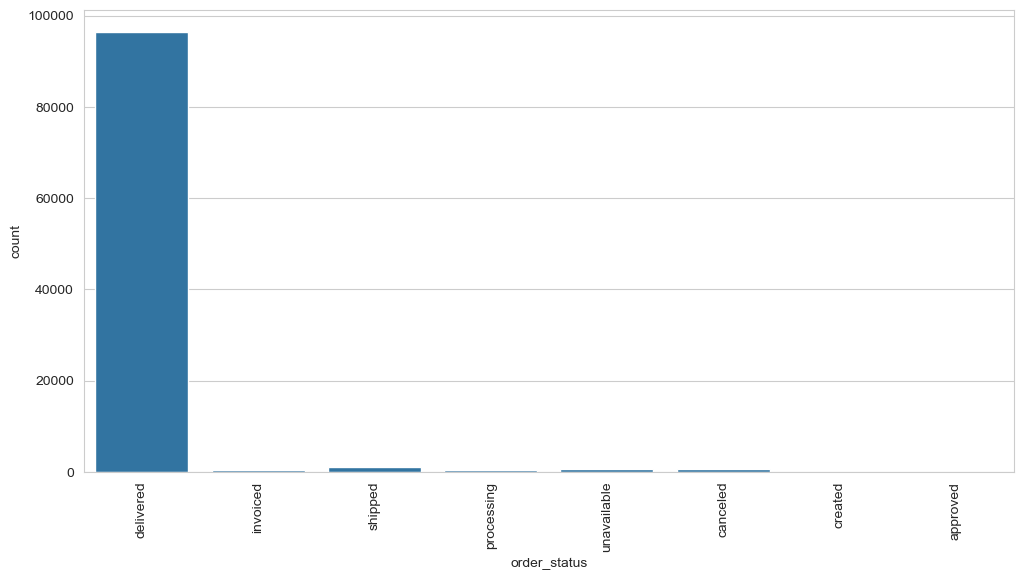

In [9]:
# =============================================================================
# ANALYZING ORDER STATUS
# =============================================================================

sns.countplot(data_orders,x= "order_status")
plt.xticks(rotation=90) 
plt.show()

In [10]:
n_delivered = (data_orders['order_status'] == "delivered").sum()
n_total = len(data_orders)
pct_delivered = n_delivered / n_total * 100

print(f"Delivered orders: {n_delivered:,} ({pct_delivered:.2f}%)")

Delivered orders: 96,478 (97.02%)


In [11]:
# =============================================================================
# DERIVING TARGET VARIABLES: DELIVERED_STATUS & WAITING_TIME
# =============================================================================

data_orders["delivered_status"] = np.where(data_orders["order_status"] == "delivered",1,0)
data_orders["waiting_time"] = (data_orders["order_delivered_customer_date"] - data_orders["order_purchase_timestamp"]).dt.days.astype("Int64")
table_exploration(data_orders, "Orders")

--- PRELIMINARY ANALYSIS: Orders ---
Shape: 99441 rows, 10 columns
Duplicate Rows: 0
------------------------------
                                        Dtype  Nulls  Null %  Uniques
order_id                               object      0    0.00    99441
customer_id                            object      0    0.00    99441
order_status                           object      0    0.00        8
order_purchase_timestamp       datetime64[ns]      0    0.00      634
order_approved_at                      object    160    0.16    90733
order_delivered_carrier_date   datetime64[ns]   1783    1.79      547
order_delivered_customer_date  datetime64[ns]   2965    2.98      645
order_estimated_delivery_date  datetime64[ns]      0    0.00      459
delivered_status                        int64      0    0.00        2
waiting_time                            Int64   2965    2.98      144
------------------------------
Quick Look (First 3 rows):


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,delivered_status,waiting_time
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02,2017-10-02 11:07:15,2017-10-04,2017-10-10,2017-10-18,1,8
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24,2018-07-26 03:24:27,2018-07-26,2018-08-07,2018-08-13,1,14
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08,2018-08-08 08:55:23,2018-08-08,2018-08-17,2018-09-04,1,9


In [12]:
# =============================================================================
# HANDLING UNDELIVERED ORDERS
# =============================================================================

# Calculating max value for delivered orders
max_waiting_observed = data_orders.loc[data_orders['delivered_status'] == 1, 'waiting_time'].max()

# Imputing with max value + penalization
data_orders['waiting_time'] = data_orders['waiting_time'].fillna(max_waiting_observed + 30)

table_exploration(data_orders, "Orders")

--- PRELIMINARY ANALYSIS: Orders ---
Shape: 99441 rows, 10 columns
Duplicate Rows: 0
------------------------------
                                        Dtype  Nulls  Null %  Uniques
order_id                               object      0    0.00    99441
customer_id                            object      0    0.00    99441
order_status                           object      0    0.00        8
order_purchase_timestamp       datetime64[ns]      0    0.00      634
order_approved_at                      object    160    0.16    90733
order_delivered_carrier_date   datetime64[ns]   1783    1.79      547
order_delivered_customer_date  datetime64[ns]   2965    2.98      645
order_estimated_delivery_date  datetime64[ns]      0    0.00      459
delivered_status                        int64      0    0.00        2
waiting_time                            Int64      0    0.00      145
------------------------------
Quick Look (First 3 rows):


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,delivered_status,waiting_time
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02,2017-10-02 11:07:15,2017-10-04,2017-10-10,2017-10-18,1,8
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24,2018-07-26 03:24:27,2018-07-26,2018-08-07,2018-08-13,1,14
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08,2018-08-08 08:55:23,2018-08-08,2018-08-17,2018-09-04,1,9


In [13]:
# =============================================================================
# DROPPING REDUNDANT COLUMNS
# =============================================================================

data_orders = data_orders.drop(columns = [
    "order_status",
    "order_approved_at",
    "order_delivered_carrier_date",
    "order_delivered_customer_date",
    "order_estimated_delivery_date"
])
table_exploration(data_orders, "Orders")

--- PRELIMINARY ANALYSIS: Orders ---
Shape: 99441 rows, 5 columns
Duplicate Rows: 0
------------------------------
                                   Dtype  Nulls  Null %  Uniques
order_id                          object      0     0.0    99441
customer_id                       object      0     0.0    99441
order_purchase_timestamp  datetime64[ns]      0     0.0      634
delivered_status                   int64      0     0.0        2
waiting_time                       Int64      0     0.0      145
------------------------------
Quick Look (First 3 rows):


,order_id,customer_id,order_purchase_timestamp,delivered_status,waiting_time
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02,1,8
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-24,1,14
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,2018-08-08,1,9


### Products & Categories Processing

**Translation to English:** 
- Products table merged with categories table to have categories names in English, then original Portuguese categories column is dropped

**Categories reduction:**
- Over 70 different categories are grouped in 6 wider categories

**Imputation strategy:**
- Dimensional variables → Imputed with **median** (numerical values, median not affected by extreme values)
- Metadata → Filled with 0 value as those products are likely ghost products
- Missing categories → Kept as separate group ("unknown") for analysis 

In [15]:
table_exploration(data_categories, "Categories")

--- PRELIMINARY ANALYSIS: Categories ---
Shape: 71 rows, 2 columns
Duplicate Rows: 0
------------------------------
                                Dtype  Nulls  Null %  Uniques
product_category_name          object      0     0.0       71
product_category_name_english  object      0     0.0       71
------------------------------
Quick Look (First 3 rows):


,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories
2,automotivo,auto


In [16]:
table_exploration(data_products, "Products")

--- PRELIMINARY ANALYSIS: Products ---
Shape: 32951 rows, 9 columns
Duplicate Rows: 0
------------------------------
                              Dtype  Nulls  Null %  Uniques
product_id                   object      0    0.00    32951
product_category_name        object    610    1.85       73
product_name_lenght         float64    610    1.85       66
product_description_lenght  float64    610    1.85     2960
product_photos_qty          float64    610    1.85       19
product_weight_g            float64      2    0.01     2204
product_length_cm           float64      2    0.01       99
product_height_cm           float64      2    0.01      102
product_width_cm            float64      2    0.01       95
------------------------------
Quick Look (First 3 rows):


,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0


In [17]:
# Analyzing missing categories

for i in data_products.product_category_name.unique():
    if i not in data_categories.product_category_name.unique():
        print(i)

nan
pc_gamer
portateis_cozinha_e_preparadores_de_alimentos


In [18]:
# =============================================================================
# TRANSLATING CATEGORIES TO ENGLISH 
# =============================================================================

# Adding new rows to the categories table with the missing categories
missing_categories = pd.DataFrame(
    {"product_category_name" : ["pc_gamer", "portateis_cozinha_e_preparadores_de_alimentos"],
     "product_category_name_english" : ["pc_gamer", "portable_kitchen_and_food_preparators"]
    }
)
data_categories = pd.concat([data_categories, missing_categories])

# Merging with products table
data_products = data_products.merge(
    data_categories,
    on = "product_category_name",
    how = "left"
)

# Dropping original Portuguese categories column
data_products = data_products.drop(columns = "product_category_name")

# Checking new table
table_exploration(data_products, "Products")

--- PRELIMINARY ANALYSIS: Products ---
Shape: 32951 rows, 9 columns
Duplicate Rows: 0
------------------------------
                                 Dtype  Nulls  Null %  Uniques
product_id                      object      0    0.00    32951
product_name_lenght            float64    610    1.85       66
product_description_lenght     float64    610    1.85     2960
product_photos_qty             float64    610    1.85       19
product_weight_g               float64      2    0.01     2204
product_length_cm              float64      2    0.01       99
product_height_cm              float64      2    0.01      102
product_width_cm               float64      2    0.01       95
product_category_name_english   object    610    1.85       73
------------------------------
Quick Look (First 3 rows):


,product_id,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english
0,1e9e8ef04dbcff4541ed26657ea517e5,40.0,287.0,1.0,225.0,16.0,10.0,14.0,perfumery
1,3aa071139cb16b67ca9e5dea641aaa2f,44.0,276.0,1.0,1000.0,30.0,18.0,20.0,art
2,96bd76ec8810374ed1b65e291975717f,46.0,250.0,1.0,154.0,18.0,9.0,15.0,sports_leisure


In [19]:
# =============================================================================
# CATEGORIES REDUCTION
# =============================================================================

categories_mapping = {
    # 1. Home and Decoration
    'furniture_decor': 'Home and Decoration', 'housewares': 'Home and Decoration', 
    'bed_bath_table': 'Home and Decoration', 'office_furniture': 'Home and Decoration',
    'home_appliances': 'Home and Decoration', 'kitchen_dining_laundry_garden_furniture': 'Home and Decoration',
    'home_confort': 'Home and Decoration', 'fixed_telephony': 'Home and Decoration',
    'small_appliances_home_oven_and_coffee': 'Home and Decoration', 'home_construction': 'Home and Decoration',
    'furniture_living_room': 'Home and Decoration', 'home_appliances_2': 'Home and Decoration',
    'furniture_bedroom': 'Home and Decoration', 'home_comfort_2': 'Home and Decoration',
    'furniture_mattress_and_upholstery': 'Home and Decoration', 'la_cuisine': 'Home and Decoration',

    # 2. Electronics and Technology
    'telephony': 'Electronics and Technology', 'electronics': 'Electronics and Technology',
    'computers_accessories': 'Electronics and Technology', 'audio': 'Electronics and Technology',
    'watches_gifts': 'Electronics and Technology', 'computers': 'Electronics and Technology',
    'portable_kitchen_and_food_preparators': 'Electronics and Technology', 'dvds_blu_ray': 'Electronics and Technology',
    'cds_dvds_musicals': 'Electronics and Technology', 'tablets_printing_image': 'Electronics and Technology',
    'pc_gamer': 'Electronics and Technology',

    # 3. Fashion and Personal Care
    'perfumery': 'Fashion and Personal Care', 'health_beauty': 'Fashion and Personal Care',
    'fashion_bags_accessories': 'Fashion and Personal Care', 'luggage_accessories': 'Fashion and Personal Care',
    'fashion_underwear_beach': 'Fashion and Personal Care', 'fashion_male_clothing': 'Fashion and Personal Care',
    'fashion_shoes': 'Fashion and Personal Care', 'fashio_female_clothing': 'Fashion and Personal Care',
    'fashion_sport': 'Fashion and Personal Care', 'fashion_childrens_clothes': 'Fashion and Personal Care',
    'diapers_and_hygiene': 'Fashion and Personal Care', 'baby': 'Fashion and Personal Care',

    # 4. Leisure, Toys and Arts
    'sports_leisure': 'Leisure, Toys and Arts', 'consoles_games': 'Leisure, Toys and Arts',
    'toys': 'Leisure, Toys and Arts', 'musical_instruments': 'Leisure, Toys and Arts',
    'art': 'Leisure, Toys and Arts', 'books_general_interest': 'Leisure, Toys and Arts',
    'books_technical': 'Leisure, Toys and Arts', 'books_imported': 'Leisure, Toys and Arts',
    'party_supplies': 'Leisure, Toys and Arts', 'cine_photo': 'Leisure, Toys and Arts',
    'music': 'Leisure, Toys and Arts', 'arts_and_craftmanship': 'Leisure, Toys and Arts',

    # 5. Tools and Construction
    'garden_tools': 'Tools and Construction', 'construction_tools_construction': 'Tools and Construction',
    'construction_tools_lights': 'Tools and Construction', 'industry_commerce_and_business': 'Tools and Construction',
    'air_conditioning': 'Tools and Construction', 'signaling_and_security': 'Tools and Construction',
    'small_appliances': 'Tools and Construction', 'costruction_tools_garden': 'Tools and Construction',
    'construction_tools_safety': 'Tools and Construction', 'costruction_tools_tools': 'Tools and Construction',
    'security_and_services': 'Tools and Construction', 'agro_industry_and_commerce': 'Tools and Construction',

    # 6. Miscellaneous and Other Items
    'cool_stuff': 'Miscellaneous and Other Items', 'pet_shop': 'Miscellaneous and Other Items',
    'food': 'Miscellaneous and Other Items', 'food_drink': 'Miscellaneous and Other Items',
    'drinks': 'Miscellaneous and Other Items', 'stationery': 'Miscellaneous and Other Items',
    'auto': 'Miscellaneous and Other Items', 'unknown': 'Miscellaneous and Other Items',
    'market_place': 'Miscellaneous and Other Items', 'flowers': 'Miscellaneous and Other Items',
    'christmas_supplies': 'Miscellaneous and Other Items'
}

data_products["product_category_name_english"] = data_products["product_category_name_english"].replace(categories_mapping)
print(f'New number of categories groups is: {data_products["product_category_name_english"].nunique()}')

New number of categories groups is: 6


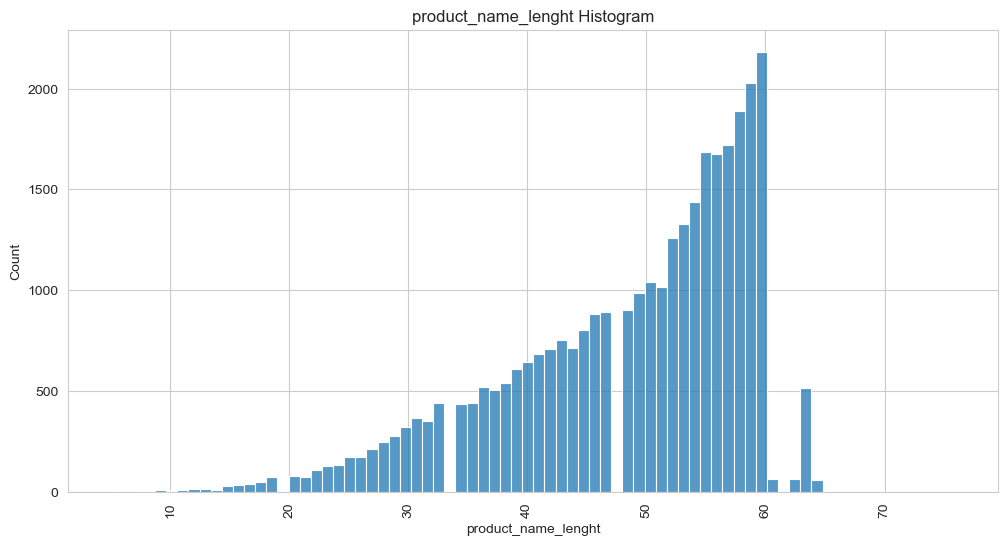

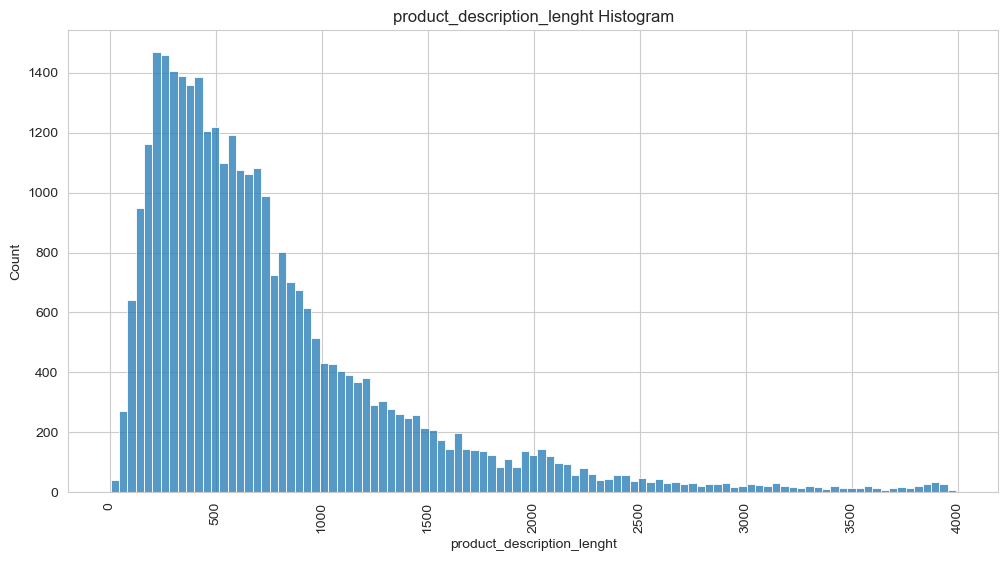

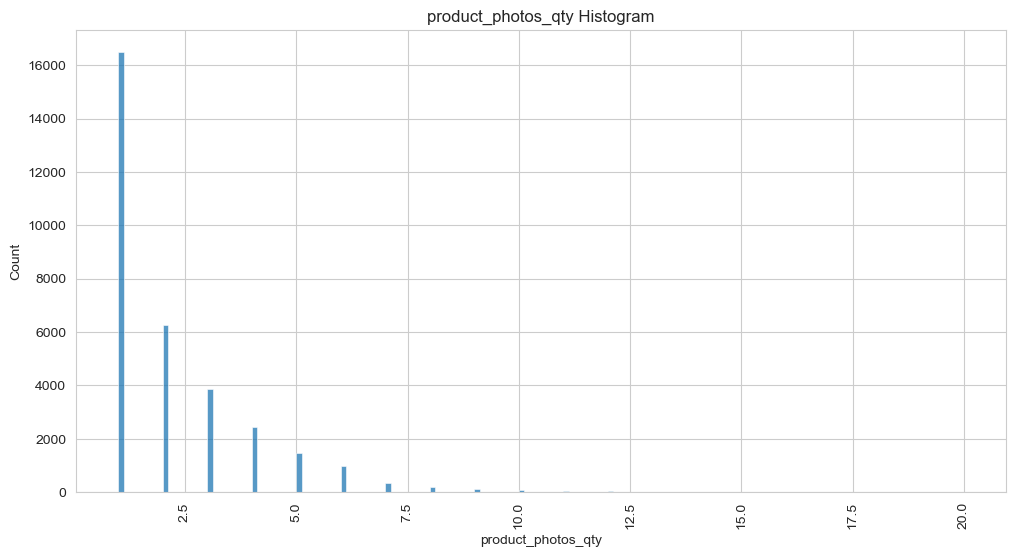

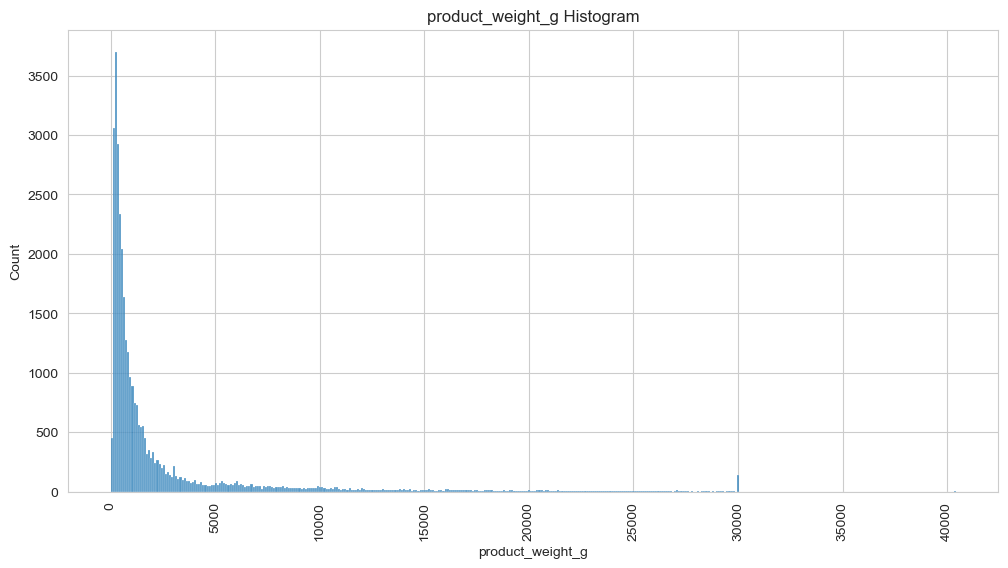

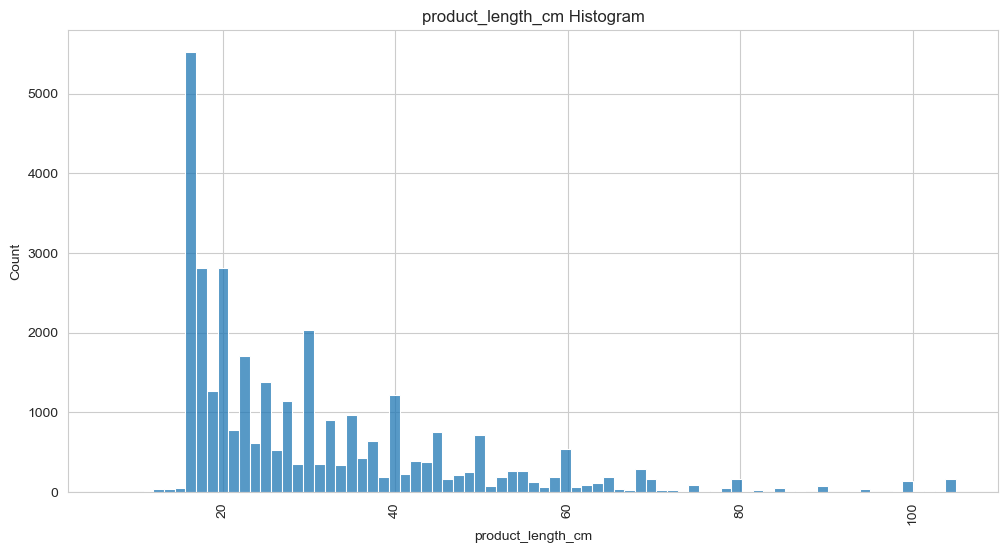

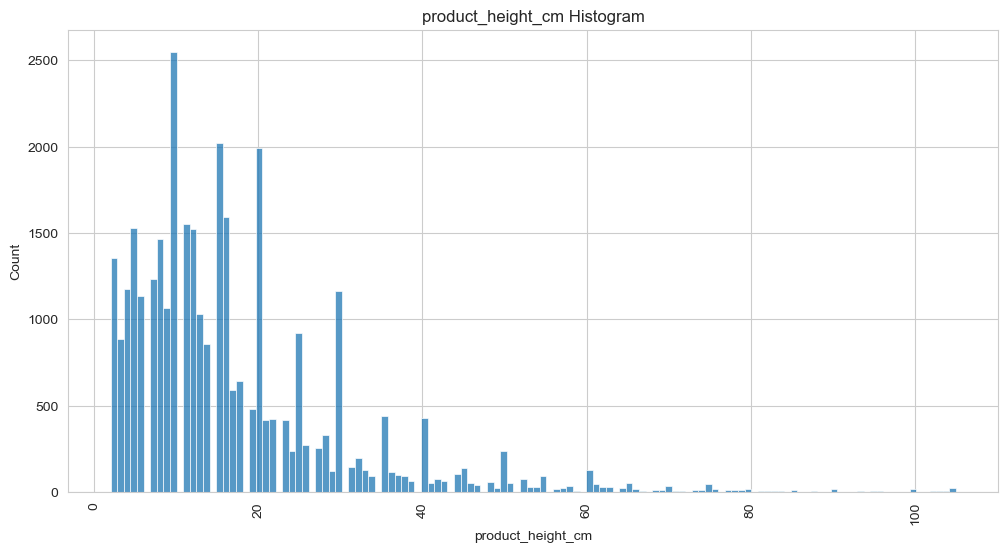

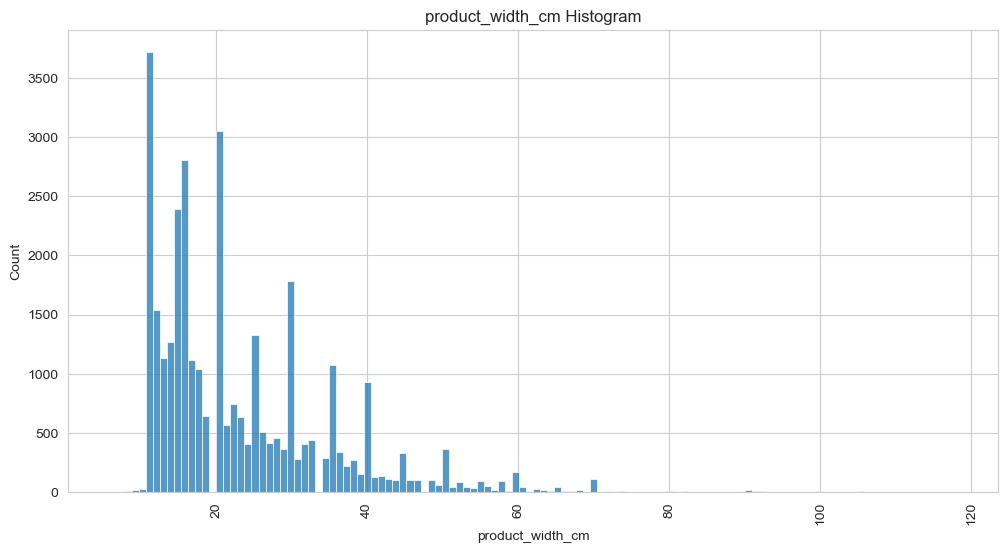

In [20]:
# =============================================================================
# VISUALIZING DISTRIBUTIONS
# =============================================================================

for col in data_products[[
    "product_name_lenght",
    "product_description_lenght",
    "product_photos_qty",
    "product_weight_g",
    "product_length_cm",
    "product_height_cm",
    "product_width_cm",
]]:
    sns.histplot(data = data_products, x = col)
    plt.title(f"{col} Histogram")
    plt.xticks(rotation = 90)
    plt.show() 

In [21]:
# =============================================================================
# HANDLING MISSING VALUES
# =============================================================================

# Creating a dictionary with the median values for each dimension
measure_list = [
    "product_weight_g", 
    "product_length_cm", 
    "product_height_cm", 
    "product_width_cm"]
median_measures = {col: data_products[col].median() for col in measure_list}

# Filling null values with the median for dimensional variables
for col in measure_list:
    data_products[col] = data_products[col].fillna(median_measures[col])
    
# Filling null values with "0" for metadata
metadata_list =[
    "product_name_lenght",
    "product_description_lenght",
    "product_photos_qty"
]
for col in metadata_list:
    data_products[col] = data_products[col].fillna(0)

# Filling null values with "Unknown" for categories
data_products["product_category_name_english"] = data_products["product_category_name_english"].fillna("Unknown")
    
# Checking new table
table_exploration(data_products, "Products")

--- PRELIMINARY ANALYSIS: Products ---
Shape: 32951 rows, 9 columns
Duplicate Rows: 0
------------------------------
                                 Dtype  Nulls  Null %  Uniques
product_id                      object      0     0.0    32951
product_name_lenght            float64      0     0.0       67
product_description_lenght     float64      0     0.0     2961
product_photos_qty             float64      0     0.0       20
product_weight_g               float64      0     0.0     2204
product_length_cm              float64      0     0.0       99
product_height_cm              float64      0     0.0      102
product_width_cm               float64      0     0.0       95
product_category_name_english   object      0     0.0        7
------------------------------
Quick Look (First 3 rows):


,product_id,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english
0,1e9e8ef04dbcff4541ed26657ea517e5,40.0,287.0,1.0,225.0,16.0,10.0,14.0,Fashion and Personal Care
1,3aa071139cb16b67ca9e5dea641aaa2f,44.0,276.0,1.0,1000.0,30.0,18.0,20.0,"Leisure, Toys and Arts"
2,96bd76ec8810374ed1b65e291975717f,46.0,250.0,1.0,154.0,18.0,9.0,15.0,"Leisure, Toys and Arts"


### Customers & Sellers Processing

**Fragmentation reduction:** We drop zip-code and city columns to reduce info fragmentation

**Normalization:** Text in state column is normalized

**Geographic grouping:** States are grouped into regions

In [23]:
table_exploration(data_customers, "Customers")

--- PRELIMINARY ANALYSIS: Customers ---
Shape: 99441 rows, 5 columns
Duplicate Rows: 0
------------------------------
                           Dtype  Nulls  Null %  Uniques
customer_id               object      0     0.0    99441
customer_unique_id        object      0     0.0    96096
customer_zip_code_prefix   int64      0     0.0    14994
customer_city             object      0     0.0     4119
customer_state            object      0     0.0       27
------------------------------
Quick Look (First 3 rows):


,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP


In [24]:
table_exploration(data_sellers, "Sellers")

--- PRELIMINARY ANALYSIS: Sellers ---
Shape: 3095 rows, 4 columns
Duplicate Rows: 0
------------------------------
                         Dtype  Nulls  Null %  Uniques
seller_id               object      0     0.0     3095
seller_zip_code_prefix   int64      0     0.0     2246
seller_city             object      0     0.0      611
seller_state            object      0     0.0       23
------------------------------
Quick Look (First 3 rows):


,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ


In [25]:
# =============================================================================
# PROCESSING
# =============================================================================

# Text normalization
data_customers["customer_state"] = data_customers["customer_state"].apply(unidecode).str.strip()
data_sellers["seller_state"] = data_sellers["seller_state"].apply(unidecode).str.strip()

# Columns dropping
data_customers = data_customers.drop(columns = ["customer_zip_code_prefix", "customer_city"])
data_sellers = data_sellers.drop(columns = ["seller_zip_code_prefix", "seller_city"])

# Checking new tables
table_exploration(data_customers, "Customers")
table_exploration(data_sellers, "Sellers")

--- PRELIMINARY ANALYSIS: Customers ---
Shape: 99441 rows, 3 columns
Duplicate Rows: 0
------------------------------
                     Dtype  Nulls  Null %  Uniques
customer_id         object      0     0.0    99441
customer_unique_id  object      0     0.0    96096
customer_state      object      0     0.0       27
------------------------------
Quick Look (First 3 rows):
--- PRELIMINARY ANALYSIS: Sellers ---
Shape: 3095 rows, 2 columns
Duplicate Rows: 0
------------------------------
               Dtype  Nulls  Null %  Uniques
seller_id     object      0     0.0     3095
seller_state  object      0     0.0       23
------------------------------
Quick Look (First 3 rows):


,seller_id,seller_state
0,3442f8959a84dea7ee197c632cb2df15,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,RJ


In [26]:
# =============================================================================
# GEOGRAPHIC GROUPING: States → Regions
# =============================================================================

region_mapping = {
    'SP': 'Southeast', 'MG': 'Southeast', 'ES': 'Southeast', 'RJ': 'Southeast',
    'RS': 'South', 'PR': 'South', 'SC': 'South',
    'BA': 'Northeast', 'PE': 'Northeast', 'CE': 'Northeast', 'MA': 'Northeast', 
    'PB': 'Northeast', 'RN': 'Northeast', 'PI': 'Northeast', 'SE': 'Northeast', 'AL': 'Northeast',
    'AM': 'North', 'PA': 'North', 'RO': 'North', 'AC': 'North', 'RR': 'North', 'AP': 'North', 'TO': 'North',
    'DF': 'Central-West', 'GO': 'Central-West', 'MT': 'Central-West', 'MS': 'Central-West'
}

data_sellers['seller_state'] = data_sellers['seller_state'].replace(region_mapping)
data_customers['customer_state'] = data_customers['customer_state'].replace(region_mapping)

print("Geographic regions consolidated")

Geographic regions consolidated


### Payments Processing

**Multiple payment methods:** Only 2.25% of orders use >1 payment type

**Processing strategy (simplified):**

Since multiple payment methods are rare (<3%), we use a simplified approach:
1. **Dominant payment method**: Method with highest payment value per order
2. **Aggregate**: Sum total payment values and number of payments (size)

**For the 2.25% with multiple methods:**
- Use their primary (highest value) payment method
- Small enough to not justify separate treatment
- Avoids feature complexity for minimal gain

**Variables created:**
- `payment_type`: Primary payment method
- `payment_value_sum`: Total amount paid
- `payment_installments`: Total payment installments (number of payments per order)

In [28]:
table_exploration(data_pay, "Payments")

--- PRELIMINARY ANALYSIS: Payments ---
Shape: 103886 rows, 5 columns
Duplicate Rows: 0
------------------------------
                        Dtype  Nulls  Null %  Uniques
order_id               object      0     0.0    99440
payment_sequential      int64      0     0.0       29
payment_type           object      0     0.0        5
payment_installments    int64      0     0.0       24
payment_value         float64      0     0.0    29077
------------------------------
Quick Look (First 3 rows):


,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71


In [29]:
# =============================================================================
# ANALYZING ORDERS WITH MULTIPLE PAYMENT METHODS
# =============================================================================

# Creating the aggregate table
data_pay_grouped = data_pay.groupby(by = "order_id").agg(
    number_payment_types = ("payment_type", "nunique")
    ).reset_index()


# Quick check for multiple methods
multi_pct = data_pay_grouped.loc[data_pay_grouped["number_payment_types"]>1].shape[0] / data_pay_grouped.shape[0]*100

# Showing result
print(f"Orders with multiple methods: {multi_pct:.2f}%")

Orders with multiple methods: 2.26%


In [30]:
# =============================================================================
# BUILDING AGGREGATE TABLE
# =============================================================================

# Aggregate values: sum of payment_value + number of payments
data_pay_grouped = data_pay.groupby(by = "order_id").agg(
    number_payments = ("order_id", "size"),
    payment_value_sum = ("payment_value", "sum")).reset_index()

# Take dominant payment method (highest value)
dominant_payment = data_pay.loc[
    data_pay.groupby('order_id')['payment_value'].idxmax(),
    ['order_id', 'payment_type']
]
    
# Add dominant payment type
data_pay_final = data_pay_grouped.merge(dominant_payment, on='order_id', how='left')
    
# Checking new table
table_exploration(data_pay_final, "Payments")

--- PRELIMINARY ANALYSIS: Payments ---
Shape: 99440 rows, 4 columns
Duplicate Rows: 0
------------------------------
                     Dtype  Nulls  Null %  Uniques
order_id            object      0     0.0    99440
number_payments      int64      0     0.0       20
payment_value_sum  float64      0     0.0    27979
payment_type        object      0     0.0        5
------------------------------
Quick Look (First 3 rows):


,order_id,number_payments,payment_value_sum,payment_type
0,00010242fe8c5a6d1ba2dd792cb16214,1,72.19,credit_card
1,00018f77f2f0320c557190d7a144bdd3,1,259.83,credit_card
2,000229ec398224ef6ca0657da4fc703e,1,216.87,credit_card


### Reviews Processing

1. **Detect multiple reviews**: Analyze frequency of multiple submissions
2. **Selection criterion**: Take LAST review (most recent opinion)
3. **Rationale**: Latest review reflects current customer satisfaction
   - Customer may have updated opinion after issue resolution
   - Most recent feedback is most relevant for business decisions

**Variables extracted:**
- `review_score`: Customer rating (1-5, discrete scale)
- `review_date`: Date of (last) review submission

**Variables dropped:**
- `review_comment_title`, `review_comment_message`: Text analysis out of scope
- `review_id`: No longer needed after consolidation

In [32]:
table_exploration(data_reviews, "Reviews")

--- PRELIMINARY ANALYSIS: Reviews ---
Shape: 99224 rows, 7 columns
Duplicate Rows: 0
------------------------------
                          Dtype  Nulls  Null %  Uniques
review_id                object      0    0.00    98410
order_id                 object      0    0.00    98673
review_score              int64      0    0.00        5
review_comment_title     object  87656   88.34     4527
review_comment_message   object  58247   58.70    36159
review_creation_date     object      0    0.00      636
review_answer_timestamp  object      0    0.00    98248
------------------------------
Quick Look (First 3 rows):


,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24


In [33]:
# =============================================================================
# ANALYZING ORDERS WITH MULTIPLE REVIEWS
# =============================================================================

reviews_per_order = data_reviews.groupby('order_id').size()
multi_review_orders = (reviews_per_order > 1).sum()
multi_review_pct = multi_review_orders / data_reviews['order_id'].nunique() * 100

print(f"Orders with multiple reviews: {multi_review_orders:,} ({multi_review_pct:.2f}%)")

Orders with multiple reviews: 547 (0.55%)


In [34]:
# =============================================================================
# HANDLING ORDERS WITH MULTIPLE REVIEWS
# =============================================================================

# Convert timestamp to datetime
data_reviews['review_answer_timestamp'] = pd.to_datetime(
    data_reviews['review_answer_timestamp']
).dt.normalize()


# Sort by timestamp and take last review
data_reviews_sorted = data_reviews.sort_values('review_answer_timestamp')
data_reviews_final = data_reviews_sorted.groupby('order_id').last().reset_index()

# Keep only relevant columns
data_reviews_final = data_reviews_final[[
    'order_id', 
    'review_score',
    'review_answer_timestamp'
]].rename(columns={
    'review_answer_timestamp': 'review_date'
})

# Check new table
table_exploration(data_reviews_final, "Reviews")

--- PRELIMINARY ANALYSIS: Reviews ---
Shape: 98673 rows, 3 columns
Duplicate Rows: 0
------------------------------
                       Dtype  Nulls  Null %  Uniques
order_id              object      0     0.0    98673
review_score           int64      0     0.0        5
review_date   datetime64[ns]      0     0.0      715
------------------------------
Quick Look (First 3 rows):


,order_id,review_score,review_date
0,00010242fe8c5a6d1ba2dd792cb16214,5,2017-09-22
1,00018f77f2f0320c557190d7a144bdd3,4,2017-05-15
2,000229ec398224ef6ca0657da4fc703e,5,2018-01-23


### Items Preprocessing

1. **Merge with products**: Products are identified by a product_id, that connects the directly to the items table, which then will be connected to the orders table
2. **Drop product_id column**: no longer necessary
3. **Detect multiple items**: Analyze frequency of orders with multiple items
4. **Selection & Aggregate criterion**: 
- products characteristics (category, seller, description...) → the most expensive product → **Rationale**: The most expensive item is more likely to drive the customer's satisfaction
- dimensional measures → max values → **Rationale**: when packing an order, the biggest object impact on the final dimensions of the parcel, which directly impacts cost and possibly customer satisfaction
- financial measures → sum → **Rationale**: it's safe to sum financial values so that we don't lose information here


**Variables extracted:**
- `number_items`: number of items per order
- `total_diff_items`: number of different items per order
- `total_price`: sum of price
- `total_freight_value`: sum of freight value

In [36]:
table_exploration(data_items, "Items")

--- PRELIMINARY ANALYSIS: Items ---
Shape: 112650 rows, 7 columns
Duplicate Rows: 0
------------------------------
                       Dtype  Nulls  Null %  Uniques
order_id              object      0     0.0    98666
order_item_id          int64      0     0.0       21
product_id            object      0     0.0    32951
seller_id             object      0     0.0     3095
shipping_limit_date   object      0     0.0    93318
price                float64      0     0.0     5968
freight_value        float64      0     0.0     6999
------------------------------
Quick Look (First 3 rows):


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.9,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.0,17.87


In [37]:
# =============================================================================
# ITEMS + PRODUCTS: Merge before aggregation
# =============================================================================

# Drooping shipping_limit_date column
data_items = data_items.drop(columns = "shipping_limit_date")

# Important: Merge products FIRST (before aggregating)
# This allows us to aggregate product characteristics

print(f"   Items before merge: {len(data_items):,}")

data_items = data_items.merge(data_products, on='product_id', how='left')

print(f"   Items after merge: {len(data_items):,}")
print(f"   Missing product info: {data_items['product_category_name_english'].isna().sum():,}")

# Check what we have now
table_exploration(data_items, "Items & Products")

   Items before merge: 112,650
   Items after merge: 112,650
   Missing product info: 0
--- PRELIMINARY ANALYSIS: Items & Products ---
Shape: 112650 rows, 14 columns
Duplicate Rows: 0
------------------------------
                                 Dtype  Nulls  Null %  Uniques
order_id                        object      0     0.0    98666
order_item_id                    int64      0     0.0       21
product_id                      object      0     0.0    32951
seller_id                       object      0     0.0     3095
price                          float64      0     0.0     5968
freight_value                  float64      0     0.0     6999
product_name_lenght            float64      0     0.0       67
product_description_lenght     float64      0     0.0     2961
product_photos_qty             float64      0     0.0       20
product_weight_g               float64      0     0.0     2204
product_length_cm              float64      0     0.0       99
product_height_cm            

,order_id,order_item_id,product_id,seller_id,price,freight_value,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,58.9,13.29,58.0,598.0,4.0,650.0,28.0,9.0,14.0,Miscellaneous and Other Items
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,239.9,19.93,56.0,239.0,2.0,30000.0,50.0,30.0,40.0,Miscellaneous and Other Items
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,199.0,17.87,59.0,695.0,2.0,3050.0,33.0,13.0,33.0,Home and Decoration


In [38]:
# =============================================================================
# ANALYZING ORDERS WITH MULTIPLE ITEMS
# =============================================================================

items_per_order = data_items.groupby('order_id').size()
multi_item_orders = (items_per_order > 1).sum()
multi_item_pct = multi_item_orders / data_items['order_id'].nunique() * 100

print(f"Orders with >1 item: {multi_item_orders:,} ({multi_item_pct:.1f}%)")
print(f"Max items in single order: {items_per_order.max()}")

Orders with >1 item: 9,803 (9.9%)
Max items in single order: 21


In [39]:
# Products characteristics for most expensive item
top_item = data_items.loc[data_items.groupby('order_id')['price'].idxmax(), 
                          ['order_id', 
                           'product_category_name_english',
                           'seller_id',
                           'product_name_lenght',
                           'product_description_lenght',
                           'product_photos_qty',
                           'product_id'
                          ]]


# Aggregate: sum for financial measures, max for dimensional measures
data_items_final = data_items.groupby('order_id').agg(
    number_items=('product_id', 'size'),
    total_price=('price', 'sum'),
    total_freight_value=('freight_value', 'sum'),
    product_weight_g=('product_weight_g', 'max'),
    product_length_cm=('product_length_cm', 'max'),
    product_height_cm=('product_height_cm', 'max'),
    product_width_cm=('product_width_cm', 'max')
).reset_index().merge(top_item, on='order_id')

# Check what we have now
table_exploration(data_items_final, "Items & Products")

--- PRELIMINARY ANALYSIS: Items & Products ---
Shape: 98666 rows, 14 columns
Duplicate Rows: 0
------------------------------
                                 Dtype  Nulls  Null %  Uniques
order_id                        object      0     0.0    98666
number_items                     int64      0     0.0       17
total_price                    float64      0     0.0     7761
total_freight_value            float64      0     0.0     7970
product_weight_g               float64      0     0.0     2192
product_length_cm              float64      0     0.0       99
product_height_cm              float64      0     0.0      102
product_width_cm               float64      0     0.0       95
product_category_name_english   object      0     0.0        7
seller_id                       object      0     0.0     3086
product_name_lenght            float64      0     0.0       67
product_description_lenght     float64      0     0.0     2953
product_photos_qty             float64      0     0.0  

,order_id,number_items,total_price,total_freight_value,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,seller_id,product_name_lenght,product_description_lenght,product_photos_qty,product_id
0,00010242fe8c5a6d1ba2dd792cb16214,1,58.9,13.29,650.0,28.0,9.0,14.0,Miscellaneous and Other Items,48436dade18ac8b2bce089ec2a041202,58.0,598.0,4.0,4244733e06e7ecb4970a6e2683c13e61
1,00018f77f2f0320c557190d7a144bdd3,1,239.9,19.93,30000.0,50.0,30.0,40.0,Miscellaneous and Other Items,dd7ddc04e1b6c2c614352b383efe2d36,56.0,239.0,2.0,e5f2d52b802189ee658865ca93d83a8f
2,000229ec398224ef6ca0657da4fc703e,1,199.0,17.87,3050.0,33.0,13.0,33.0,Home and Decoration,5b51032eddd242adc84c38acab88f23d,59.0,695.0,2.0,c777355d18b72b67abbeef9df44fd0fd


## Dataset Consolidation

**Base table:** Reviews (orders with customer feedback)  
**Join type:** LEFT JOIN (preserve all reviews)

In [41]:
# =============================================================================
# MERGE SEQUENCE
# =============================================================================

print("Starting merges...\n")

# BASE: Reviews
final_data = data_reviews_final.copy()
print(f"Base (reviews): {len(final_data):,} orders")

# 1. Orders
initial = len(final_data)
final_data = final_data.merge(data_orders, on='order_id', how='left')
print(f"+ Orders: {len(final_data):,} (change: {len(final_data)-initial:+})")

# 2. Customers
initial = len(final_data)
final_data = final_data.merge(data_customers, on='customer_id', how='left')
final_data = final_data.drop(columns=['customer_id'])  # Keep only customer_unique_id
print(f"+ Customers: {len(final_data):,} (change: {len(final_data)-initial:+})")

# 3. Payments
initial = len(final_data)
final_data = final_data.merge(data_pay_final, on='order_id', how='left')
print(f"+ Payments: {len(final_data):,} (change: {len(final_data)-initial:+})")

# 4. Items
initial = len(final_data)
final_data = final_data.merge(data_items_final, on='order_id', how='left')
print(f"+ Items: {len(final_data):,} (change: {len(final_data)-initial:+})")

# 5. Sellers
initial = len(final_data)
final_data = final_data.merge(data_sellers, on='seller_id', how='left')
print(f"+ Sellers: {len(final_data):,} (change: {len(final_data)-initial:+})")

print(f"\n FINAL DATASET: {final_data.shape}")

Starting merges...

Base (reviews): 98,673 orders
+ Orders: 98,673 (change: +0)
+ Customers: 98,673 (change: +0)
+ Payments: 98,673 (change: +0)
+ Items: 98,673 (change: +0)
+ Sellers: 98,673 (change: +0)

 FINAL DATASET: (98673, 25)


In [42]:
# =============================================================================
# FINAL DATA RECAP
# =============================================================================

table_exploration(final_data, "Final Data")

--- PRELIMINARY ANALYSIS: Final Data ---
Shape: 98673 rows, 25 columns
Duplicate Rows: 0
------------------------------
                                        Dtype  Nulls  Null %  Uniques
order_id                               object      0    0.00    98673
review_score                            int64      0    0.00        5
review_date                    datetime64[ns]      0    0.00      715
order_purchase_timestamp       datetime64[ns]      0    0.00      634
delivered_status                        int64      0    0.00        2
waiting_time                            Int64      0    0.00      142
customer_unique_id                     object      0    0.00    95380
customer_state                         object      0    0.00        5
number_payments                       float64      1    0.00       20
payment_value_sum                     float64      1    0.00    27869
payment_type                           object      1    0.00        5
number_items                          fl

,order_id,review_score,review_date,order_purchase_timestamp,delivered_status,waiting_time,customer_unique_id,customer_state,number_payments,payment_value_sum,...,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,seller_id,product_name_lenght,product_description_lenght,product_photos_qty,product_id,seller_state
0,00010242fe8c5a6d1ba2dd792cb16214,5,2017-09-22,2017-09-13,1,7,871766c5855e863f6eccc05f988b23cb,Southeast,1.0,72.19,...,28.0,9.0,14.0,Miscellaneous and Other Items,48436dade18ac8b2bce089ec2a041202,58.0,598.0,4.0,4244733e06e7ecb4970a6e2683c13e61,Southeast
1,00018f77f2f0320c557190d7a144bdd3,4,2017-05-15,2017-04-26,1,16,eb28e67c4c0b83846050ddfb8a35d051,Southeast,1.0,259.83,...,50.0,30.0,40.0,Miscellaneous and Other Items,dd7ddc04e1b6c2c614352b383efe2d36,56.0,239.0,2.0,e5f2d52b802189ee658865ca93d83a8f,Southeast
2,000229ec398224ef6ca0657da4fc703e,5,2018-01-23,2018-01-14,1,8,3818d81c6709e39d06b2738a8d3a2474,Southeast,1.0,216.87,...,33.0,13.0,33.0,Home and Decoration,5b51032eddd242adc84c38acab88f23d,59.0,695.0,2.0,c777355d18b72b67abbeef9df44fd0fd,Southeast


In [43]:
# =============================================================================
# REMOVING NULL VALUES (<1%)
# =============================================================================

final_data_clean = final_data.dropna(subset=['number_items', 'number_payments'])
print(f"Removed {len(final_data) - len(final_data_clean)} orders with no items or payments info")

table_exploration(final_data_clean, "Final Data")

Removed 757 orders with no items or payments info
--- PRELIMINARY ANALYSIS: Final Data ---
Shape: 97916 rows, 25 columns
Duplicate Rows: 0
------------------------------
                                        Dtype  Nulls  Null %  Uniques
order_id                               object      0     0.0    97916
review_score                            int64      0     0.0        5
review_date                    datetime64[ns]      0     0.0      711
order_purchase_timestamp       datetime64[ns]      0     0.0      615
delivered_status                        int64      0     0.0        2
waiting_time                            Int64      0     0.0      142
customer_unique_id                     object      0     0.0    94720
customer_state                         object      0     0.0        5
number_payments                       float64      0     0.0       20
payment_value_sum                     float64      0     0.0    27737
payment_type                           object      0     0.0

,order_id,review_score,review_date,order_purchase_timestamp,delivered_status,waiting_time,customer_unique_id,customer_state,number_payments,payment_value_sum,...,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,seller_id,product_name_lenght,product_description_lenght,product_photos_qty,product_id,seller_state
0,00010242fe8c5a6d1ba2dd792cb16214,5,2017-09-22,2017-09-13,1,7,871766c5855e863f6eccc05f988b23cb,Southeast,1.0,72.19,...,28.0,9.0,14.0,Miscellaneous and Other Items,48436dade18ac8b2bce089ec2a041202,58.0,598.0,4.0,4244733e06e7ecb4970a6e2683c13e61,Southeast
1,00018f77f2f0320c557190d7a144bdd3,4,2017-05-15,2017-04-26,1,16,eb28e67c4c0b83846050ddfb8a35d051,Southeast,1.0,259.83,...,50.0,30.0,40.0,Miscellaneous and Other Items,dd7ddc04e1b6c2c614352b383efe2d36,56.0,239.0,2.0,e5f2d52b802189ee658865ca93d83a8f,Southeast
2,000229ec398224ef6ca0657da4fc703e,5,2018-01-23,2018-01-14,1,8,3818d81c6709e39d06b2738a8d3a2474,Southeast,1.0,216.87,...,33.0,13.0,33.0,Home and Decoration,5b51032eddd242adc84c38acab88f23d,59.0,695.0,2.0,c777355d18b72b67abbeef9df44fd0fd,Southeast


## Data extraction

In [45]:
# =============================================================================
# EXPORTING THE DATA TO A CSV FILE
# =============================================================================

final_data_clean.to_csv("Olist_clean_data.csv", index = False)

print("✅ The data was successfully exported!")

✅ The data was successfully exported!
